In [1]:
%pylab inline
import os, sys

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge


from tqdm.notebook import tqdm

tqdm.pandas()
sys.path.append('..')
import assign_loop_type
from assign_loop_type import write_loop_assignments

Populating the interactive namespace from numpy and matplotlib


### Modified degscore for Wayment-Steele, ... et al. arXiv 2022

The original DegScore predicted all 0's for the first 10 nucleotides due to the padding at runtime. For predicting summed values over entire RNA sequences, this was not apparent, but for comparing nucleotide-to-nucleotide, this resulted in erroneously high MCRMSE values. The above code copies the process of creating the DegScore model but with a `pad` of 0.

In [12]:
def encode_input(df, window_size=1, pad=0, seq=True, struct=True, ensemble_size=0):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    seq (bool): include sequence encoding
    struct (bool): include bpRNA structure encoding
    
    Outputs:
    Input array (n_samples x n_features): array of windowed input features
    feature_names (list): feature names
    
    '''
    #MAX_LEN = 68
    BASES = ['A','U','G','C']
    STRUCTS = ['H','E','I','M','B','S']
    
    inpts = []
    labels = []

    feature_kernel=[]
    if seq:
        feature_kernel.extend(BASES)
    if struct:
        feature_kernel.extend(STRUCTS)

    feature_names = ['%s_%d' % (k, val) for val in range(-1*window_size, window_size+1) for k in feature_kernel]
    
    for i, row in tqdm(df.iterrows(), desc='Encoding inputs', total=len(df)):
        MAX_LEN = row['seq_scored']
        
        arr = np.zeros([MAX_LEN,len(feature_kernel)])
        
        if ensemble_size > 0: # stochastically sample ensemble
            ensemble = get_ensemble(row['sequence'], n=ensemble_size)
        else: # use MEA structure
            ensemble = np.array([list(row['predicted_loop_type'])])

        for index in range(pad,MAX_LEN):
            ctr=0

            #encode sequence
            if seq:
                for char in BASES:
                    if row['sequence'][index]==char:
                        arr[index,ctr]+=1
                    ctr+=1

            if struct:
                loop_assignments = ''.join(ensemble[:,index])
                for char in STRUCTS:
                    prob = loop_assignments.count(char) / len(loop_assignments)
                    arr[index,ctr]+=prob
                    ctr+=1
                    
        # add zero padding to the side
        padded_arr = np.vstack([np.zeros([window_size,len(feature_kernel)]),arr[pad:], np.zeros([window_size,len(feature_kernel)])])

        for index in range(pad,MAX_LEN):
            new_index = index+window_size-pad
            tmp = padded_arr[new_index-window_size:new_index+window_size+1]
            inpts.append(tmp.flatten())
            labels.append('%s_%d' % (row['id'], index))
            
    return np.array(inpts), feature_names, labels

def encode_output(df, data_type='reactivity', pad=0):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    data_type: column name for degradation
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    
    Outputs:
    output array (n_samples): array of reactivity values
    
    '''
    #MAX_LEN = 68
    
    outpts = []
    labels = []
    # output identity should be in form id_00073f8be_0

    for i, row in df.iterrows():
        MAX_LEN = row['seq_scored']
        
        for index in range(pad,MAX_LEN):
            outpts.append(row[data_type][index])
            labels.append('%s_%d' % (row['id'], index))
            
            
    return outpts, labels

#### Load data 

In [13]:
kaggle_train = pd.read_json('train.json',lines=True)
kaggle_train = kaggle_train.loc[kaggle_train['SN_filter']==1]

kaggle_test = pd.read_json('test.json',lines=True)

In [11]:
kaggle_train.keys()

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

#### Encode data

###### Max. expected accuracy

In [14]:
inputs_train, feature_names, _ = encode_input(kaggle_train, window_size=12)
inputs_test, _, test_labels = encode_input(kaggle_test, window_size=12)

#### Visualize encoding for an example nucleotide

Text(0.5, 0, 'window position')

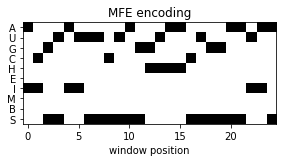

In [12]:
figure(figsize=(10,4))
subplot(1,2,1)
title('MFE encoding')
imshow(np.array(inputs_train[33].reshape(25,10)).T,cmap='gist_heat_r')
yticks(range(10), ['A','U','G','C','H','E','I','M','B','S'])
xlabel('window position')

#### To set up kaggle submission format:

In [15]:
sample_submission = pd.read_csv('sample_submission.csv.zip')
mask = sample_submission['id_seqpos'].isin(test_labels)

#### Train models

#### Model based on single MFE structure (primary DegScore model used)

In [17]:
for output_type in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C','deg_50C']:
    outputs_train, outputs_labels = encode_output(kaggle_train, data_type=output_type)

    reg = Ridge(alpha=0.15, fit_intercept=False)
    print('Fitting %s ...' % output_type)
    #reg.fit(mea_inputs_train_construct, mea_outputs_train)
    reg.fit(inputs_train, outputs_train)
        
    test_prediction = reg.predict(inputs_test)
    sample_submission.loc[mask, output_type] = test_prediction

Fitting reactivity ...
Fitting deg_Mg_pH10 ...
Fitting deg_pH10 ...
Fitting deg_Mg_50C ...
Fitting deg_50C ...


In [20]:
sample_submission.to_csv('mar82022_v1.csv',index=False)